# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0,0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

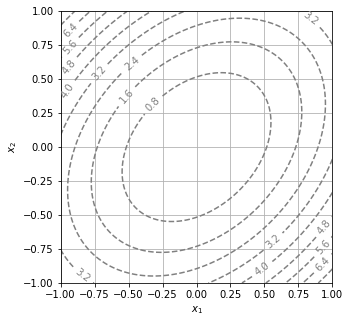

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

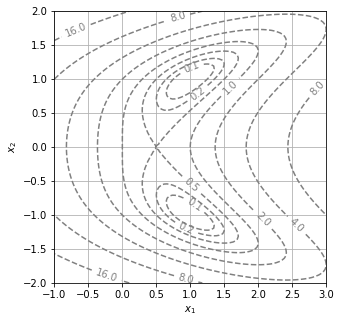

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

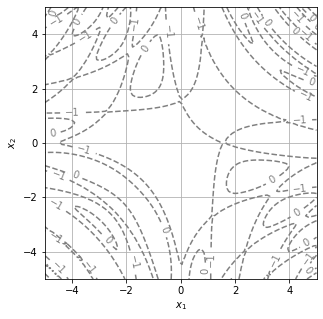

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=[-1,0], # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [79]:
N = 100
eps = 10**(-3)

Justification : Avec epsilon = 0.001, nous pouvons supposer que ces deux points ne changent plus. De même que le fait que epsilon doit être inférieur à delta pour trouver la courbe de niveau. En même temps, en raison des limites de la puissance de calcul, l'epsilon ne peut être trop petit, ce qui entraîne des temps de calcul trop longs.


**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [80]:
def Newton(F, x0, y0, eps=eps, N=N):
    J_F = J(F)
    x, y = x0, y0
    for i in range(N):
        # on calcule l'inverse de jacobien à la main
        # car on rencontre des problèmes de python en ulitisant la méthode np.linalg.inv
        x = x + (-F(x,y)[0]*J_F(x,y)[1][1]+F(x,y)[1]*J_F(x,y)[0][1])/(J_F(x,y)[0][0]*J_F(x,y)[1][1]-J_F(x,y)[1][0]*J_F(x,y)[0][1])
        y = y + (-F(x,y)[0]*J_F(x,y)[1][0]+F(x,y)[1]*J_F(x,y)[0][0])/(J_F(x,y)[0][1]*J_F(x,y)[1][0]-J_F(x,y)[1][1]*J_F(x,y)[0][0])   
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [81]:
def F1(x,y):
    return np.array([f1(x, y)-0.8, y-x])

In [83]:
x1, y1 = Newton(F1, 0.8, 0.8)
x1, y1

(0.4472135957814878, 0.44721359554693757)

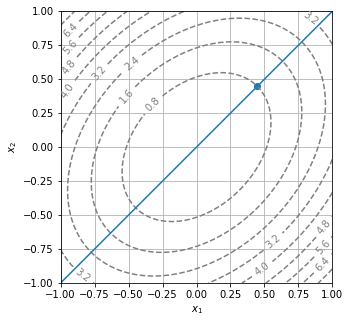

In [17]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.scatter(x1, y1)
X = np.linspace(-1.0, 1.0, 100)
Y = X
plt.plot(X,Y)
plt.show()

On fait varier le point de référence à (0.5, 0.5).

In [84]:
x2, y2 = Newton(F1, 0.5, 0.5)
x2, y2

(0.44721359553781376, 0.4472135955119499)

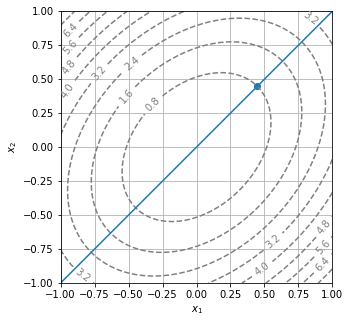

In [19]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.scatter(x2, y2)
X = np.linspace(-1.0, 1.0, 100)
Y = X
plt.plot(X,Y)
plt.show()

On fait varier la contrainte supplémentaire avec y = 2x.

In [85]:
def F2(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.array([f1(x, y)-0.8, 2*x-y])

In [86]:
x3, y3 = Newton(F2, 0.8, 0.8)
x3, y3

(0.2696799449919554, 0.5393598899769023)

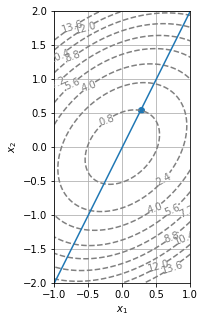

In [87]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-2, 2, 400), 
    levels=[1.6*i-0.8 for i in range(10)]
)
plt.scatter(x3, y3)
X = np.linspace(-1.0, 1.0 ,100)
plt.plot(X, 2*X)
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [23]:
def norme(u):   # On définit la norme d'un vecteur
    return np.sqrt(u[0]**2 + u[1]**2)

In [24]:
# On définit une nouvelle méthode Newton car on veut ajouter deux fonctions:
# on cherche le point de sorte qu'il soit "à droite" du point initial
# on ne veut pas apparaître des erreurs quand l'algorithme ne converge pas
def Newton2(F, f, x0, y0, delta, eps=eps, N=N):
    J_F = J(F)
    grad_f = grad(f)
    
    x0 = x0 + grad_f(x0, y0)[1] / norme(grad_f(x0, y0)) * delta 
    y0 = y0 - grad_f(x0, y0)[0] / norme(grad_f(x0, y0)) * delta
    # Nous utilisons ces équations pour déterminer la direction du mouvement vers "la droite"

    for i in range(N):
        # on calcule le Jacobien à la main
        x = x0 + (-F(x0,y0)[0]*J_F(x0,y0)[1][1]+F(x0,y0)[1]*J_F(x0,y0)[0][1])/(J_F(x0,y0)[0][0]*J_F(x0,y0)[1][1]-J_F(x0,y0)[1][0]*J_F(x0,y0)[0][1])
        y = y0 + (-F(x0,y0)[0]*J_F(x0,y0)[1][0]+F(x0,y0)[1]*J_F(x0,y0)[0][0])/(J_F(x0,y0)[0][1]*J_F(x0,y0)[1][0]-J_F(x0,y0)[1][1]*J_F(x0,y0)[0][0]) 
        
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps :   
            return x, y
        else:
            x0,y0 = x,y 
    return x, y

In [25]:
def level_curve(f, x0, y0, c, delta=0.1, N=1000, eps=eps):
    res = []
    
    for i in range(N):
        def F(x,y):
            return np.array([f(x,y)-c, (x-x0)**2 + (y-y0)**2 - delta**2])
        # Pour appliquer la méthode Newton, on doit définir une fonction F à partir de f qui est de R^2 à R^2
        # La permière composante signifie qu'on voudrait obtenir des points sur la courbe de niveaur c
        # La seconde composante signifie qu'on voudrait chercher le point qui est de distance delta au point courant
        x0, y0 = Newton2(F, f, x0, y0, delta, eps=eps, N=N)
        res.append([x0, y0])
        
    res = np.array(res)
    return res

In [26]:
lcf1 = level_curve(f1, 0.5, 0.5, 1.0)
lcf1

array([[ 0.56011298,  0.42008311],
       [ 0.59710015,  0.32717238],
       [ 0.61182932,  0.2282614 ],
       ...,
       [ 0.45242702, -0.23831455],
       [ 0.38926618, -0.31596095],
       [ 0.31863121, -0.38684358]])

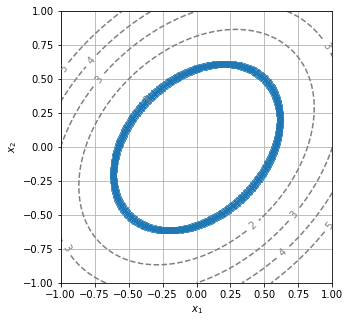

In [27]:
display_contour(f1,
x = np.linspace(-1.0, 1.0, 100), 
y = np.linspace(-1.0, 1.0, 100), 
levels = np.linspace(0, 5, 6))

plt.plot(lcf1[:,0], lcf1[:,1], 'x')

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [28]:
def level_curve_2(f, x0, y0, c, delta=0.01, N=1000, eps=0.01):
    res = []    
    x_o,y_o = x0, y0
    
    def F(x,y):
        return np.array([f(x,y) - c, (x-x0)**2 + (y-y0)**2 - delta**2])
        
    for i in range(N): 
        x, y = Newton2(F, f, x0, y0, delta, eps=eps, N=N)
        if norme([x_o-x, y_o-y]) >= delta:    # on continue si la distance entre le point courant et le point initial est plus grande que delta
            x0, y0 =x, y 
            res.append([x, y])
        else:
            break
            
    res = np.array(res)
    return res  

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

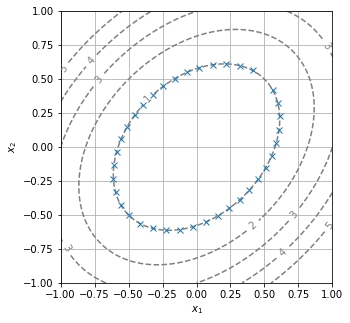

In [89]:
lc2_f1 = level_curve_2(f1, 0.5, 0.5, 1.0, delta=0.1)

display_contour(f1,
x = np.linspace(-1.0, 1.0, 100), 
y = np.linspace(-1.0, 1.0, 100), 
levels = np.linspace(0, 5, 6))

plt.plot(lc2_f1[:,0], lc2_f1[:,1], 'x')

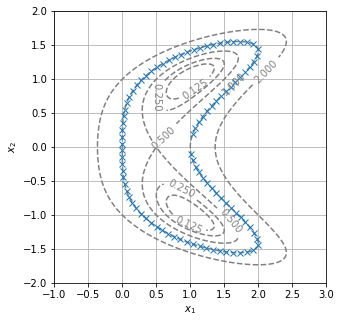

In [98]:
lc2_f2 = level_curve_2(f2, 1.0, 0.0, 1.0, delta=0.1)

display_contour(f2,
x = np.linspace(-1.0, 3.0, 200), 
y = np.linspace(-2.0, 2.0, 200), 
levels = [2**i for i in range(-3, 2)])

plt.plot(lc2_f2[:,0], lc2_f2[:,1], 'x')

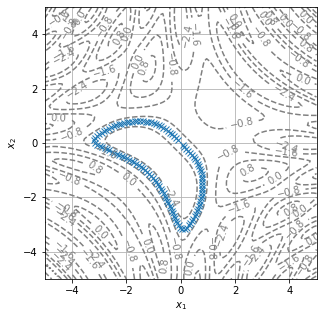

In [100]:
lc2_f3 = level_curve_2(f3, 0.0, 0.0, -2.0, delta=0.1)

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

plt.plot(lc2_f3[:,0], lc2_f3[:,1], 'x')

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [31]:
def disque(x, y):
    return x**2 + y**2

In [55]:
def area_squares(f, c, h, delta=0.1):
    
    # On définit (x0, y0) de sorte que f(x0, y0) ne soit pas très loin de c 
    # pour ne pas occuper trop de mémoire en ulitisant la méthode Newton
    x0 = 1.0
    y0 = 0.0
    
    res = level_curve_2(f, x0, y0, c, delta=delta, N=1000, eps=0.01)
    # on recherche les valeurs maximales et minimales dans les directions x et y (afin d'encadrer les lignes de contour).
    limite_d = np.max(res[:, 0])
    limite_g = np.min(res[:, 0])
    limite_h = np.max(res[:, 1])
    limite_b = np.min(res[:, 1])
    
    a = int((limite_d - limite_g) / h)
    b = int((limite_h - limite_b) / h)
    X = np.linspace(limite_g, limite_d, num=a, endpoint=False)
    Y = np.linspace(limite_b, limite_h, num=b, endpoint=False)
    
    m = 0
    for x in X+(limite_d-limite_g)/(2*a):
        for y in Y+(limite_h-limite_b)/(2*b):
            if f(x,y) <= c: #le point au centre
                m+=1
    return(m * ((limite_d-limite_g)/a) * ((limite_h-limite_b)/b))

In [56]:
area_squares(disque, 1.0, 0.001)

3.1408857871503546

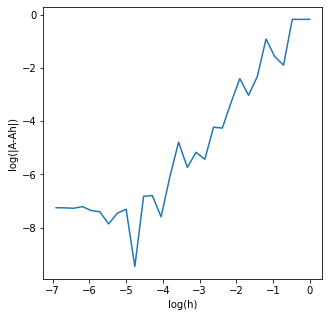

In [34]:
s = np.linspace(-3, 0, 30)
h_liste = 10**s
erreur = [abs(area_squares(disque, 1.0, h) - np.pi) for h in h_liste]

plt.xlabel('log(h)')
plt.ylabel('log(|A-Ah|)')
plt.plot(np.log(h_liste), np.log(erreur))
plt.show()

C'est-à-dire que l'erreur diminue avec la diminuation du 'pas' $h$.

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


**Réponse** Cette méthode utilise le centroïde de chaque grille pour déterminer si un point se trouve à l'intérieur d'une ligne de contour (courbe de niveau). Si nous changeons cette condition pour dire que tant que l'un des quatre sommets d'une grille est à l'intérieur de la ligne de contour, il est considéré comme étant à l'intérieur, alors la zone résultante doit être plus grande que la figure originale. C'est un encardrement.
Pour donner un encadrement à $10^{-2}$ près, on peut diminuer la valeur de $h$.



In [37]:
def encadrement(f,c,h):
    
    x0 = 1.0
    y0 = 0.0
    
    res = level_curve_2(f, x0, y0, c, delta=0.1, N=1000, eps=0.01)
    limite_d = np.max(res[:, 0])
    limite_g = np.min(res[:, 0])
    limite_h = np.max(res[:, 1])
    limite_b = np.min(res[:, 1])
    
    a = int((limite_d - limite_g) / h)
    b = int((limite_h - limite_b) / h)
    X = np.linspace(limite_g, limite_d, num = a, endpoint = False)
    Y = np.linspace(limite_b, limite_h, num = b, endpoint = False)
    
    m = 0
    for x in X + (limite_d-limite_g) / (2 * a):
        for y in Y + (limite_h-limite_b) / (2 * b):
            # si un des quatres sommets est dans l;intérieur de la courbe de niveau
            if (f(x + h/2, y + h/2) <= c) or (f(x + h/2, y - h/2) <= c) or (f(x - h/2, y + h/2) <= c) or (f(x - h/2, y - h/2) <= c):
                m+=1
    return(m * ((limite_d-limite_g)/a) * ((limite_h-limite_b)/b))

In [75]:
encadre = encadrement(disque, 1.0, 0.01)

In [76]:
(encadre - np.pi)/encadre # h = 0.01 ne suffit pas

0.01122395529748693

In [77]:
encadre_2 = encadrement(disque, 1.0, 0.001)

In [78]:
(encadre_2 - np.pi)/encadre_2 # h = 0.001 suffit

0.0009767957687797178

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [39]:
# On définit cette fonction pour calculer l'aire d'un triangle
def triangle(x1,x2,x3):
    v1 = x2 - x3
    v2 = x1 - x2
    return np.cross(v1, v2)/2

In [104]:
def Bn(delta):
    
    z = level_curve_2(disque, 1.0, 0.0, 1.0, delta = delta, N = 10000)
    p = (0, 0)

    aire = 0

    for i in range (len(z)):
        aire += abs(triangle(p, z[i], z[i-1]))

    return aire

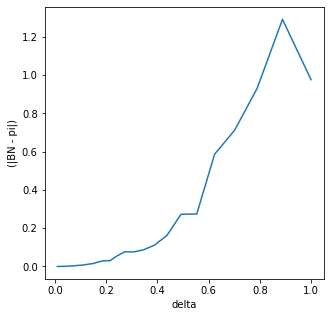

In [105]:
delta_liste = 10**np.linspace(-2, 0, 40)

Y_incertitued = [abs(Bn(delta) - np.pi) for delta in delta_liste]

plt.plot(delta_liste, (Y_incertitued))
plt.xlabel('delta')
plt.ylabel('(|BN - pi|)')
plt.show()

On voit très clairement que l'erreur du résultat obtenu avec la vraie valeur diminue avec $n$ augmente ($\delta$ diminue). Autrement dit, $B_N$ converge vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0.

In [58]:
# vitesse de convergence
vitesse_n = [] 
for i in range(len(Y_incertitued)):
    vitesse_n.append(Y_incertitued[-i] / Y_incertitued[-i-1])

Text(0, 0.5, 'vitesse de convergence')

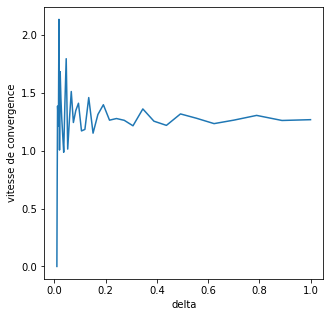

In [59]:
plt.plot(delta_liste, vitesse_n)
plt.xlabel('delta')
plt.ylabel('vitesse de convergence')

La vitesse de convergence augmente avec $\delta$ diminue.

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [67]:
def area_disque_exterieur(delta):
    
    z = level_curve_2(disque, 1.0, 0.0, 1.0, delta = delta, N = 10000)
    p = (5,0)
    aire = 0

    for i in range (len(z)):
        x1= z[i]
        x2= z[i-1]
        aire += triangle(x1,x2,p)

    return abs(aire)

In [68]:
area_disque_exterieur(0.01)

3.141539463703395

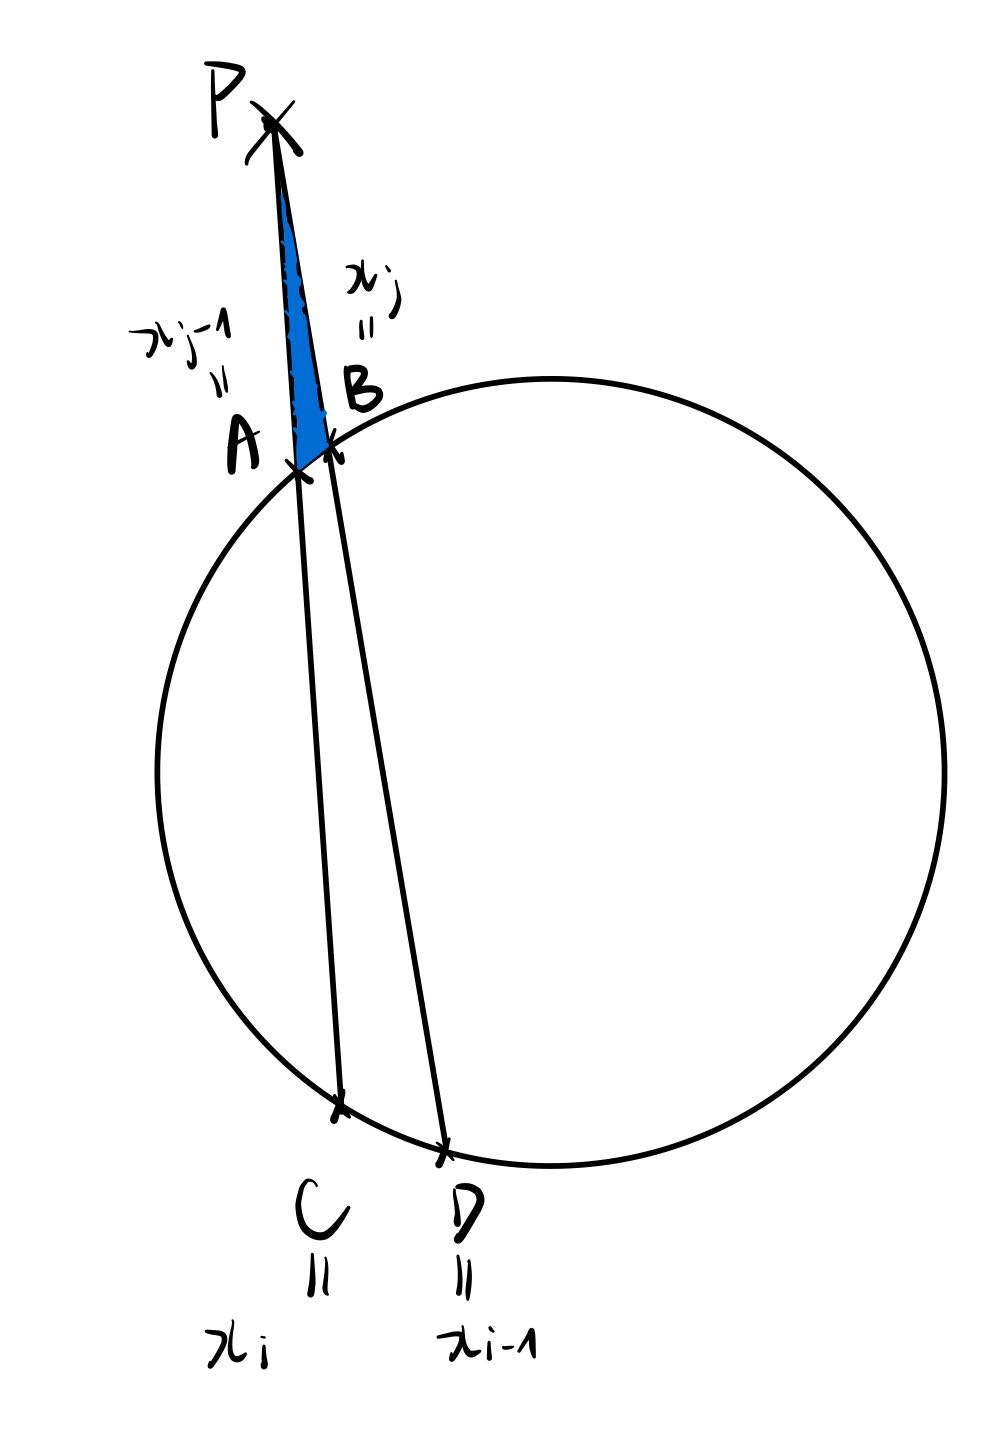

**Reponse** On utilise le produit vectoriel pour calculer l'aire du triangle, c'est la raison qu'on obtient l'aire négative. Soit un point P à l'ectérieure de K, soient A et B deux points sur K suffisamment proches. Supposons que PA et PB ne sont pas tangentes à K, alors on peut trouver un point C à la fois sur K et sur la ligne PA, et un point D à la fois sur K et sur la ligne PB. De plus, ABCD est inclus dans K car K est convexe. Selon la méthode qu'on obtient la courbe de niveau, on sait que l'ordre dans lequel les quatres points A,B,C,D sont stockés dans le tableau Numpy est A,B,D,C. Donc la somme de l'aire des triangles PAB et PBC en utilisant le prodiut vectoriel pour calculer est l'aire de ABCD. On obtient ainsi le bon comportement pour le point P à l'extérieur de K.

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [42]:
def reunion_de_disques(x, y):
    if x < 0:
        res = (x + 1)**2 + y**2
    else:
        res = (x - 1)**2 + y**2
    return (res)

In [45]:
def area_reunion(delta):
    
    z = level_curve_2(reunion_de_disques, 3.0, 0.0, 4.0, delta = delta, N = 10000)
    p = (0,0)
    aire = 0

    for i in range (len(z)):
        x1= z[i]
        x2= z[i-1]
        aire += triangle(x1, x2, p)

    return abs(aire)

In [46]:
area_reunion(0.01)

20.21922067782736

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [47]:
def area_triangles(x,y):
    p = (0,0)
    aire = 0

    for i in range (len(x)):
        x1 = np.array((x[i], y[i]))
        x2 = np.array((x[i-1], y[i-1]))
        aire += triangle(x1, x2, p)

    return abs(aire)

## Comparaison

**1. Ajustements de la précision**

Avec $delta$ = 0.1

In [52]:
disque_ligne = level_curve_2(disque, 1.0, 0.0, 1.0, delta=0.1, N=1000, eps=0.01)

In [59]:
x_t = area_triangles(disque_ligne[:,0], disque_ligne[:,1])
x_t

3.1349038349626634

In [60]:
x_s = area_squares(disque, 1.0, 0.01)
x_s

3.1419097910786884

In [63]:
d_t = np.abs(x_t - np.pi)
d_t

0.006688818627129667

In [64]:
d_s = np.abs(x_s - np.pi)
d_s

0.0003171374888952805

Avec $delta$ = 0.01

In [66]:
disque_ligne2 = level_curve_2(disque, 1.0, 0.0, 1.0, delta=0.01, N=1000, eps=0.01)

In [67]:
x_t = area_triangles(disque_ligne2[:,0], disque_ligne2[:,1])
x_t

3.141539463703397

In [68]:
x_s = area_squares(disque, 1.0, 0.01, 0.01)
x_s

3.1431687742422842

In [69]:
d_t = np.abs(x_t - np.pi)
d_t

5.3189886396243224e-05

In [70]:
d_s = np.abs(x_s - np.pi)
d_s

0.0015761206524911309

En modifiant le delta, nous savons que la précision de la méthode de carre n'augmente pas nécessairement, mais que la précision de la méthode de triangle peut être améliorée en ajustant le delta. 

La méthode de triangle peut être ajustée pour la précision avec la courbe de niveau plus précise. Et la vitesse de convergence est de l'ordre grandeur de delta^2, alors il converge vite.

Cependant,nous savons que pour la méthode de carre, l'ajustement de la largeur de la grille h est le meilleur moyen de pouvoir ajuster la précision.Sa précision est liée au delta, mais n'en dépend pas entièrement, et dans les cas où la courbe de niveau est très imprécise, on peut aussi obtenir une meilleure précision en ajustant h.

**2. Vitesse de fonctionnement**

La méthode de carrés est de complexité en 1/h^2 + 1/delta.

La méthode de triangles est de complexité en 1/delta.

Alors la méthode de carrés est plus lente.

**3. Encadrement**

La méthode de carrés permet la possibilité d'encadrement de la valeur.Mais la méthode de triangles ne peut pas avoir l'encadrement.
